In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# SIMD

In [14]:
# compilers=["intel", "gcc", "clang"]
compilers = ["gcc"]


def get_layout(s):
    return s[s.find("<") - 3 : s.find("<")]


def get_container(s):
    if "Vec" in s:
        return "std::vector"
    elif "Arr" in s:
        return "std::array"
    else:
        return "Raw"

def get_container_inv(s):    
    if "std::vector" in s:
        return "Vec"
    elif "std::array" in s:
        return "Arr"
    else:
        return "Raw"

def get_nmembers(row):
    lo = row["layout"]
    cntr = get_container_inv(row["container"])
    cntr_pos = row["name"].find(cntr)
    lo_pos = row["name"].rfind(lo) + len(lo)
    return int(row["name"][lo_pos:cntr_pos])


def get_type(s):
    return s.split("<")[2].split(",")[0].strip()

def get_operation(s):
    larrow = s.find("<")
    start = s.find("BM_") + 3
    return s[start : larrow - 3]

In [15]:
def read_file(results, cmplr, commit, autovec):
    with open(f"simd/results_{cmplr}_{commit}_{autovec}", "r") as read_file:
        data = json.load(read_file)
        df = pd.DataFrame.from_dict(data["benchmarks"]).astype({"real_time": float})
        df["layout"] = df["name"].apply(get_layout)
        df["container"] = df["name"].apply(get_container)
        df["nmembers"] = df.apply(get_nmembers, axis=1)
        df["type"] = df["name"].apply(get_type)
        df["operation"] = df["name"].apply(get_operation)
        results[f"{cmplr}_{autovec}"] = df


commit = "ad35ff8"
results = {}
for cmplr in compilers:
    read_file(results, cmplr, commit, "novec")
    read_file(results, cmplr, commit, "vec")

results["gcc_vec"]

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,time_unit,instructions,size,aggregate_name,aggregate_unit,layout,container,nmembers,type,operation
0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",0,0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",iteration,10,0.0,1,89,7.838701,...,ms,6.750023e+07,10000000.0,NaN,NaN,AoS,Raw,2,float,MulAdd
1,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",0,0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",iteration,10,1.0,1,89,7.838620,...,ms,6.750023e+07,10000000.0,NaN,NaN,AoS,Raw,2,float,MulAdd
2,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",0,0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",iteration,10,2.0,1,89,7.834874,...,ms,6.750023e+07,10000000.0,NaN,NaN,AoS,Raw,2,float,MulAdd
3,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",0,0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",iteration,10,3.0,1,89,7.837955,...,ms,6.750023e+07,10000000.0,NaN,NaN,AoS,Raw,2,float,MulAdd
4,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",0,0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",iteration,10,4.0,1,89,7.847998,...,ms,6.750023e+07,10000000.0,NaN,NaN,AoS,Raw,2,float,MulAdd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",95,0,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",iteration,10,9.0,1,5,149.905910,...,ms,2.110000e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,SqrtLog
1340,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",95,0,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",aggregate,10,NaN,1,10,149.855556,...,ms,2.110000e+09,10000000.0,mean,time,SoA,std::vector,20,double,SqrtLog
1341,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",95,0,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",aggregate,10,NaN,1,10,149.873121,...,ms,2.110000e+09,10000000.0,median,time,SoA,std::vector,20,double,SqrtLog
1342,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",95,0,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",aggregate,10,NaN,1,10,0.246262,...,ms,0.000000e+00,0.0,stddev,time,SoA,std::vector,20,double,SqrtLog


In [16]:
df_mean = {}
df_median = {}
df_std = {}
df_runs = {}

for cmplr, df in results.items():
    df_mean[cmplr] = df[df["aggregate_name"] == "mean"]
    df_median[cmplr] = df[df["aggregate_name"] == "median"]
    df_std[cmplr] = df[df["aggregate_name"] == "stddev"]
    df_runs[cmplr] = df[df["aggregate_name"].isna()]

num_tests = df_runs["gcc_novec"]["family_index"].max() + 1
df_runs["gcc_novec"]

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,time_unit,instructions,size,aggregate_name,aggregate_unit,layout,container,nmembers,type,operation
0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",0,0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",iteration,10,0.0,1,77,9.098897,...,ms,1.475002e+08,10000000.0,NaN,NaN,AoS,Raw,2,float,MulAdd
1,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",0,0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",iteration,10,1.0,1,77,9.103851,...,ms,1.475002e+08,10000000.0,NaN,NaN,AoS,Raw,2,float,MulAdd
2,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",0,0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",iteration,10,2.0,1,77,9.096311,...,ms,1.475002e+08,10000000.0,NaN,NaN,AoS,Raw,2,float,MulAdd
3,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",0,0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",iteration,10,3.0,1,77,9.093144,...,ms,1.475002e+08,10000000.0,NaN,NaN,AoS,Raw,2,float,MulAdd
4,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",0,0,"BM_MulAddAoS<AoS2Raw<float, vector_size>>/manu...",iteration,10,4.0,1,77,9.207098,...,ms,1.475002e+08,10000000.0,NaN,NaN,AoS,Raw,2,float,MulAdd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",95,0,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",iteration,10,5.0,1,5,143.255720,...,ms,2.160000e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,SqrtLog
1336,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",95,0,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",iteration,10,6.0,1,5,143.428435,...,ms,2.160000e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,SqrtLog
1337,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",95,0,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",iteration,10,7.0,1,5,143.383047,...,ms,2.160000e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,SqrtLog
1338,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",95,0,"BM_SqrtLogSoA<SoA20Vec<double, vector_size>>/m...",iteration,10,8.0,1,5,143.267999,...,ms,2.160000e+09,10000000.0,NaN,NaN,SoA,std::vector,20,double,SqrtLog


## Bar Chart

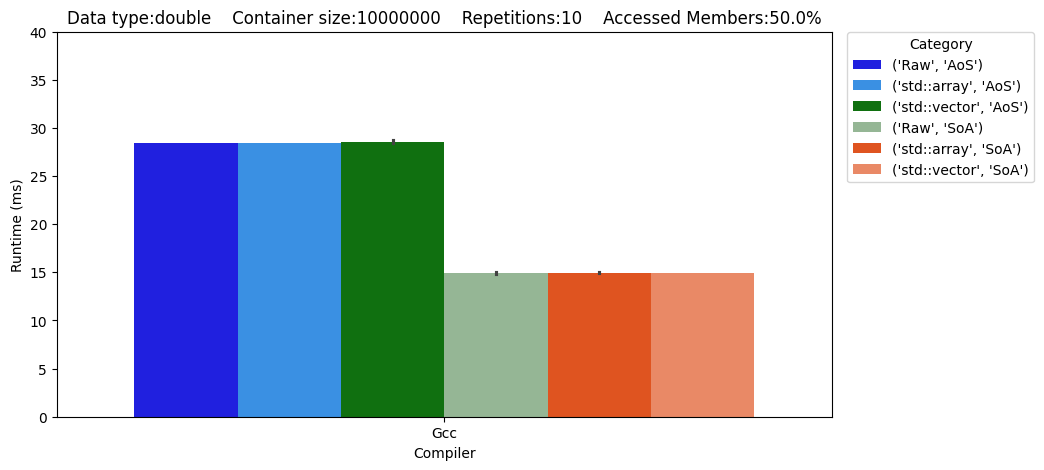

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,time_unit,instructions,size,aggregate_name,aggregate_unit,layout,container,nmembers,type,operation
826,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,0.0,1,46,14.895520,...,ms,6.250028e+07,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
827,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,1.0,1,46,14.887740,...,ms,6.250028e+07,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
828,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,2.0,1,46,14.888557,...,ms,6.250028e+07,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
829,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,3.0,1,46,14.928529,...,ms,6.250028e+07,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
830,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,4.0,1,46,14.889401,...,ms,6.250028e+07,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
831,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,5.0,1,46,14.878522,...,ms,6.250028e+07,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
832,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,6.0,1,46,14.900983,...,ms,6.250028e+07,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
833,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,7.0,1,46,14.889363,...,ms,6.250028e+07,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
834,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,8.0,1,46,14.882508,...,ms,6.250028e+07,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
835,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,9.0,1,46,14.887211,...,ms,6.250028e+07,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd


In [17]:
selected_type = "double"
selected_size = list(df_runs.values())[0]["size"].mean()
selected_reps = list(df_runs.values())[0]["repetitions"].mean()
selected_unit = list(df_runs.values())[0]["time_unit"].values[0]
selected_operation = "MulAdd"
selected_nmembers = 4


def plot_bars(autovec):
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(111)
    plt.title(
        f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}    Accessed Members:{(2/selected_nmembers)*100}%"
    )
    data = {"Category": [], "Compiler": [], "Runtime": []}

    for cmplr in compilers:
        df_cmplr = df_runs[f"{cmplr}_{autovec}"]
        for lo in df_cmplr["layout"].unique():
            for cntr in df_cmplr["container"].unique():
                runs = df_cmplr[
                    (df_cmplr["operation"] == selected_operation)
                    & (df_cmplr["nmembers"] == selected_nmembers)
                    & (df_cmplr["type"] == selected_type)
                    & (df_cmplr["layout"] == lo)
                    & (df_cmplr["container"] == cntr)
                ]
                data["Category"].extend(
                    [(c, l) for c, l in zip(runs["container"], runs["layout"])]
                )
                data["Compiler"].extend(np.repeat(cmplr.title(), selected_reps))
                data["Runtime"].extend(runs["real_time"])

    df = pd.DataFrame(data)

    palette = [
        "b",
        "dodgerblue",
        "green",
        "darkseagreen",
        "orangered",
        "coral",
    ]
    sns.barplot(
        x="Compiler",
        y="Runtime",
        hue="Category",
        palette=palette,
        data=df,
    )

    plt.ylim([0, 40])
    plt.ylabel(f"Runtime ({selected_unit})")
    plt.legend(
        title="Category", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0
    )

    # plt.savefig(
    #     f"images/simd_{selected_type}_{commit}.pdf", format="pdf", bbox_inches="tight"
    # )
    plt.show()

    return runs


plot_bars("vec")

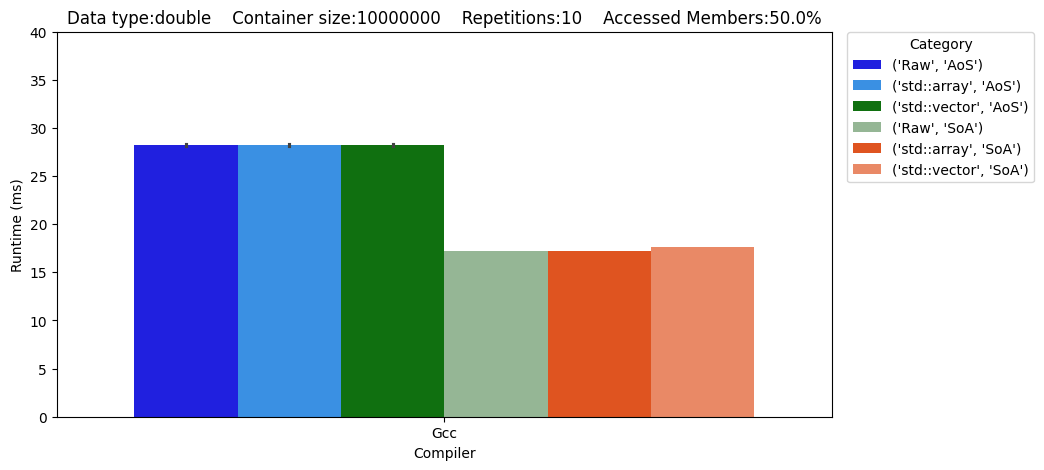

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,time_unit,instructions,size,aggregate_name,aggregate_unit,layout,container,nmembers,type,operation
826,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,0.0,1,40,17.581740,...,ms,1.575003e+08,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
827,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,1.0,1,40,17.610589,...,ms,1.575003e+08,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
828,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,2.0,1,40,17.619261,...,ms,1.575003e+08,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
829,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,3.0,1,40,17.606607,...,ms,1.575003e+08,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
830,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,4.0,1,40,17.605001,...,ms,1.575003e+08,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
831,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,5.0,1,40,17.600475,...,ms,1.575003e+08,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
832,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,6.0,1,40,17.640922,...,ms,1.575003e+08,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
833,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,7.0,1,40,17.612519,...,ms,1.575003e+08,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
834,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,8.0,1,40,17.610018,...,ms,1.575003e+08,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd
835,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",59,0,"BM_MulAddSoA<SoA4Vec<double, vector_size>>/man...",iteration,10,9.0,1,40,17.604647,...,ms,1.575003e+08,10000000.0,NaN,NaN,SoA,std::vector,4,double,MulAdd


In [18]:
plot_bars("novec")

## Line Chart

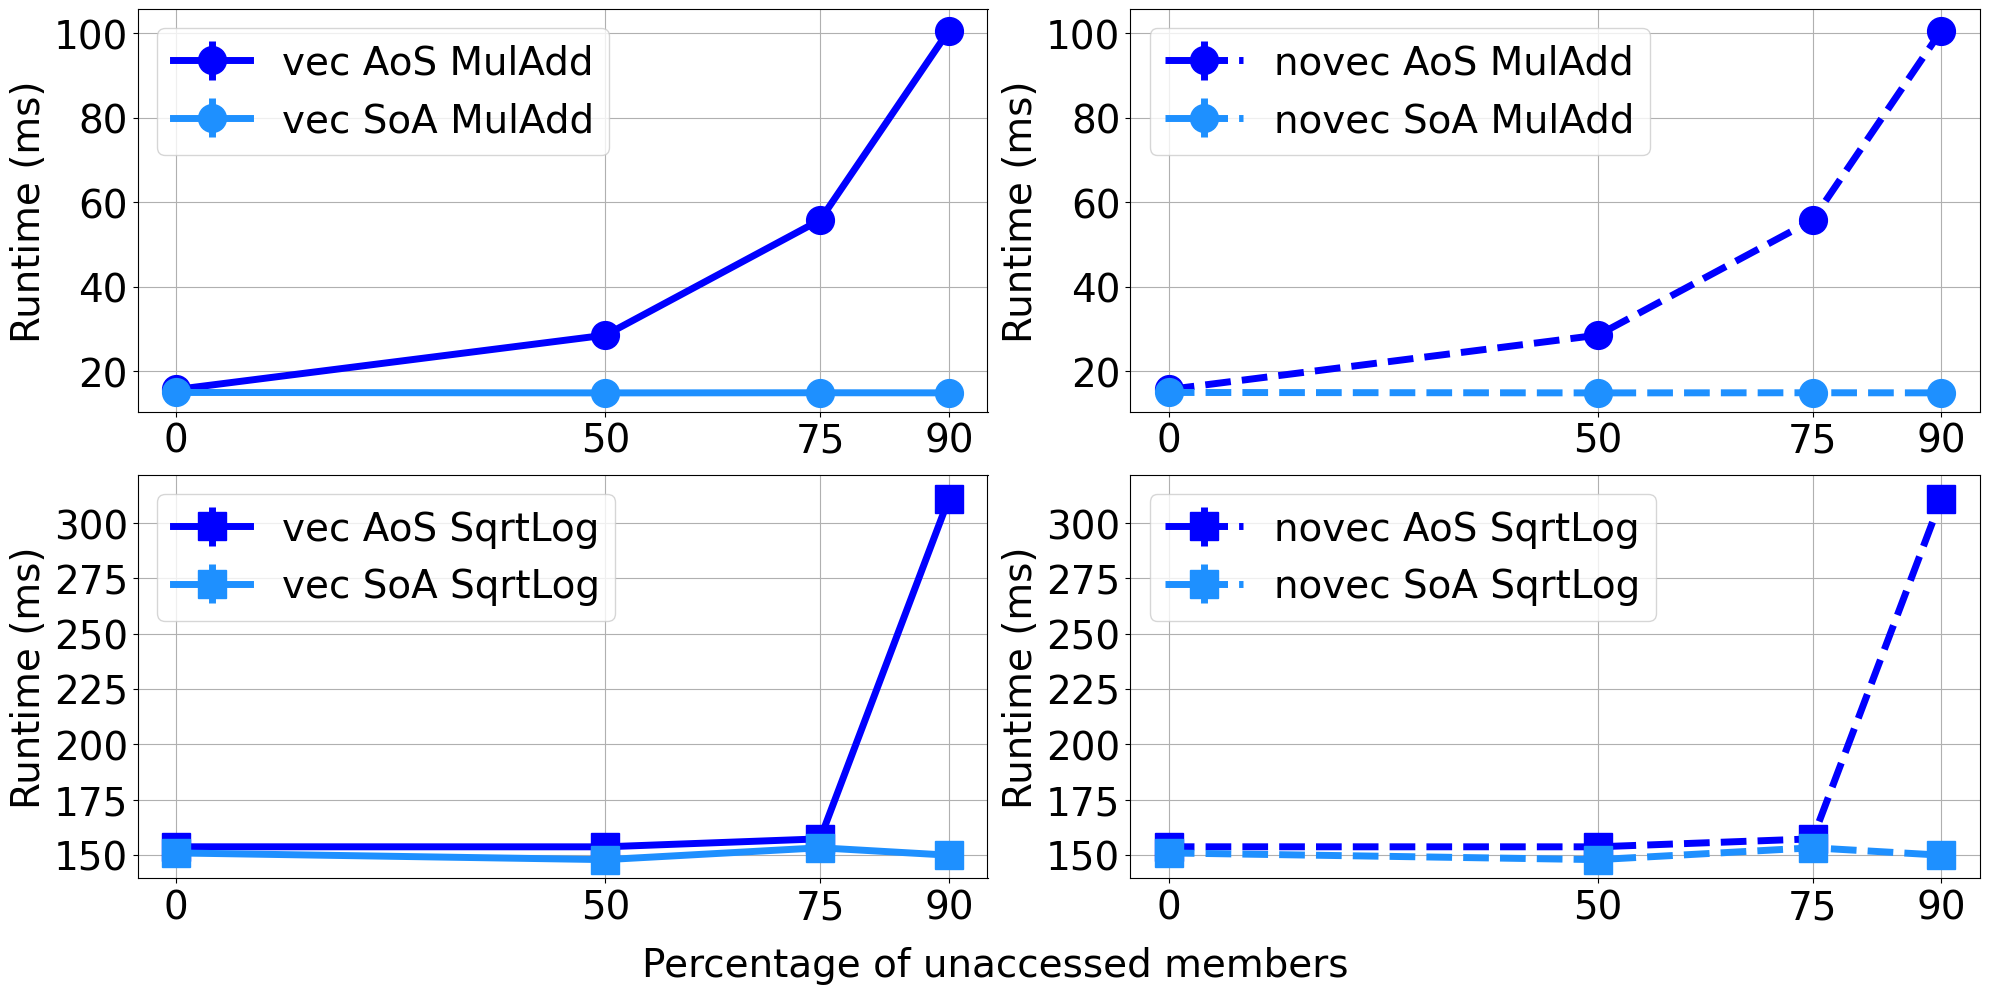

array([ 0., 50., 75., 90.])

In [20]:
import itertools

selected_type = "double"
selected_size = list(df_mean.values())[0]["size"].mean()
selected_reps = list(df_mean.values())[0]["repetitions"].mean()
selected_unit = list(df_mean.values())[0]["time_unit"].values[0]
selected_cmplr = "gcc"
selected_container = "std::vector"
selected_op = "MulAdd"


fig = plt.figure(figsize=(20, 10))
# plt.title(
#     f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}"
# )

avg = df_mean[f"{selected_cmplr}_vec"].copy()
std = df_std[f"{selected_cmplr}_vec"].copy()
markers = ["o", "s", "D", "^", "v", "P", "X", "p", "h", "d", "H", "8", "1", "2", "3", "4", "8", "s", "p", "P", "*", "x", "X", "D", "d", "h", "H", "v", "^", "<", ">"]
linestyles = ["-", "--", "-.", ":"]
colors = [
    "b",
    "dodgerblue",
    "green",
    "darkseagreen",
    "orangered",
    "coral",
]
    
nmembers_list = avg["nmembers"].unique()
for oi, selected_op in enumerate(avg["operation"].unique()):
    for vi, selected_vec in enumerate(["vec", "novec"]):
        ax = plt.subplot(2,2, oi*2+vi+1)
        for li, selected_lo in enumerate(avg["layout"].unique()):
            avg_filtered = avg[(avg["type"] == selected_type)
                & (avg["container"] == selected_container)
                & (avg["layout"] == selected_lo)
                & (avg["operation"] == selected_op)]
            std_filtered = std[ (std["type"] == selected_type)
                & (std["container"] == selected_container)
                & (std["layout"] == selected_lo)
                & (std["operation"] == selected_op)]
            
            x = (nmembers_list-2)/nmembers_list*100
            plt.errorbar(
                x,
                avg_filtered["real_time"],
                yerr=std_filtered["real_time"],
                label=f"{selected_vec} {selected_lo} {selected_op}",
                marker=markers[oi],
                color=colors[li],
                ls=linestyles[vi],
                lw=5, ms=20
        )

        plt.xticks(x, fontsize=28)
        plt.yticks(fontsize=28)

        # plt.xlim([0, 110])
        plt.ylabel(f"Runtime ({selected_unit})", fontsize=28)
        plt.xticks(x)
        plt.legend(loc="upper left", fontsize=28)

        plt.grid()

fig.supxlabel("Percentage of unaccessed members", fontsize=28)

plt.tight_layout()
plt.savefig(f"images/simd_{selected_type}_{commit}.png", format="png", bbox_inches="tight")
plt.show()
x

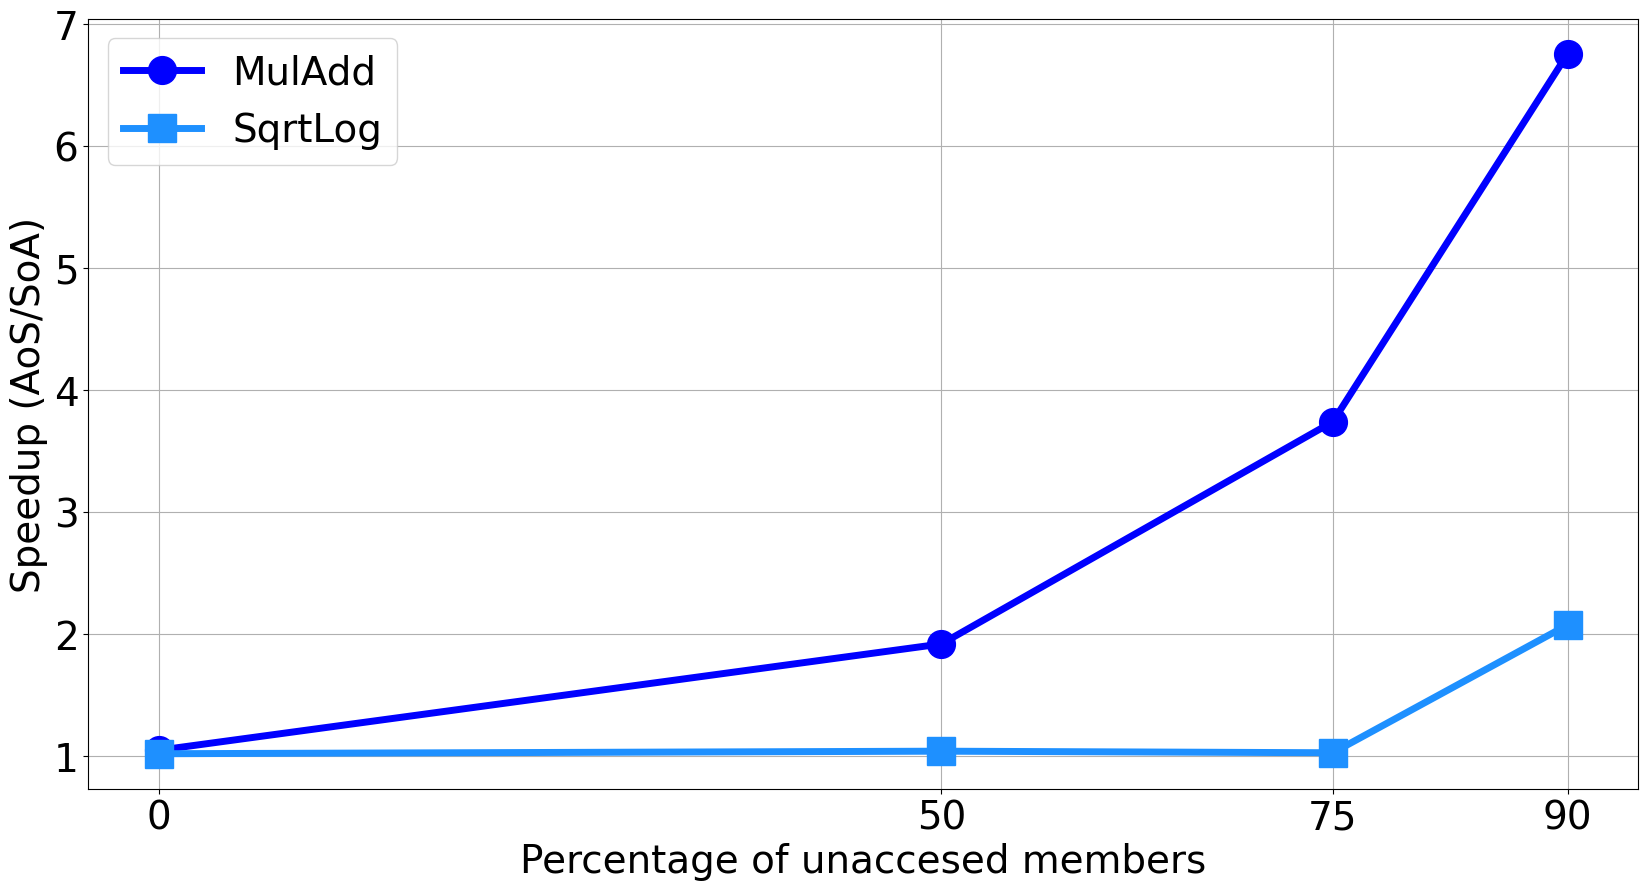

In [22]:
import itertools

selected_type = "double"
selected_size = list(df_mean.values())[0]["size"].mean()
selected_reps = list(df_mean.values())[0]["repetitions"].mean()
selected_unit = list(df_mean.values())[0]["time_unit"].values[0]
selected_cmplr = "gcc"
selected_container = "std::vector"
selected_op = "MulAdd"


plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
# plt.title(
#     f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}"
# )

avg = df_mean[f"{selected_cmplr}_vec"].copy()
std = df_std[f"{selected_cmplr}_vec"].copy()
markers = ["o", "s", "D", "^", "v", "P", "X", "p", "h", "d", "H", "8", "1", "2", "3", "4", "8", "s", "p", "P", "*", "x", "X", "D", "d", "h", "H", "v", "^", "<", ">"]
linestyles = ["-", "--", "-.", ":"]
colors = [
    "b",
    "dodgerblue",
    "green",
    "darkseagreen",
    "orangered",
    "coral",
]

def map_vec(s):
    if s == "vec":
        return "SIMD"
    else:
        return "No SIMD"
    
nmembers_list = avg["nmembers"].unique()
for oi, selected_op in enumerate(avg["operation"].unique()):
    for vi, selected_vec in enumerate(["novec"]):
        avg_filtered = avg[(avg["type"] == selected_type)
            & (avg["container"] == selected_container)
            & (avg["operation"] == selected_op)]
        std_filtered = std[ (std["type"] == selected_type)
            & (std["container"] == selected_container)
            & (std["operation"] == selected_op)]
        avg_aos = avg_filtered[avg_filtered["layout"] == "AoS"]
        std_aos = std_filtered[std_filtered["layout"] == "AoS"]
        avg_soa = avg_filtered[avg_filtered["layout"] == "SoA"]
        std_soa = std_filtered[std_filtered["layout"] == "SoA"]
        
        x = (nmembers_list-2)/nmembers_list*100
        plt.errorbar(
            x,
            avg_aos["real_time"].values/avg_soa["real_time"],
            # yerr=std_aos,
            label=f"{selected_op}",
            marker=markers[oi],
            color=colors[oi],
            ls=linestyles[vi*2],
            lw=5, ms=20
        )

        plt.xticks(x, fontsize=28)
        plt.yticks(fontsize=28)
        plt.xlabel("Percentage of unaccessed members", fontsize=28)
        plt.ylabel(f"Speedup (AoS/SoA)", fontsize=28)
        
# plt.ylim([0, 40])
plt.ylabel(f"Speedup (AoS/SoA)")
plt.legend(loc="upper left", fontsize=28)
plt.grid()

# plt.xlim([0, 110])
plt.xticks(x)
plt.xlabel("Percentage of unaccesed members")
plt.savefig(f"images/simd_{selected_type}_{commit}_speedup.png", format="png", bbox_inches="tight")
plt.show()


In [ ]:
avg_aos["real_time"].values/avg_soa["real_time"]

1088    1.018409
1172    1.039210
1256    1.026356
1340    2.074860
Name: real_time, dtype: float64

In [ ]:
avg_aos

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,...,time_unit,instructions,size,aggregate_name,aggregate_unit,layout,container,nmembers,type,operation
1074,"BM_SqrtLogAoS<AoS2Vec<double, vector_size>>/ma...",76,0,"BM_SqrtLogAoS<AoS2Vec<double, vector_size>>/ma...",aggregate,10,NaN,1,10,153.658534,...,ms,2.130000e+09,10000000.0,mean,time,AoS,std::vector,2,double,SqrtLog
1158,"BM_SqrtLogAoS<AoS4Vec<double, vector_size>>/ma...",82,0,"BM_SqrtLogAoS<AoS4Vec<double, vector_size>>/ma...",aggregate,10,NaN,1,10,153.642498,...,ms,2.130000e+09,10000000.0,mean,time,AoS,std::vector,4,double,SqrtLog
1242,"BM_SqrtLogAoS<AoS8Vec<double, vector_size>>/ma...",88,0,"BM_SqrtLogAoS<AoS8Vec<double, vector_size>>/ma...",aggregate,10,NaN,1,10,157.248308,...,ms,2.130000e+09,10000000.0,mean,time,AoS,std::vector,8,double,SqrtLog
1326,"BM_SqrtLogAoS<AoS20Vec<double, vector_size>>/m...",94,0,"BM_SqrtLogAoS<AoS20Vec<double, vector_size>>/m...",aggregate,10,NaN,1,10,310.929295,...,ms,2.130001e+09,10000000.0,mean,time,AoS,std::vector,20,double,SqrtLog


In [ ]:
x

array([ 0., 50., 75., 90.])

## Box Plots

In [ ]:
selected_type = "double"
selected_size = df_runs["intel"]["size"].mean()
selected_reps = df_runs["intel"]["repetitions"].mean()

plt.figure(figsize=(10, 5))
plt.title(
    f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}"
)
data = {"Category": [], "Compiler": [], "Runtime": []}
for cmplr, avg, std in zip(compilers, df_mean.values(), df_std.values()):
    for i in range(num_tests):
        df_cmplr = df_runs[cmplr]
        runs = df_cmplr[(df_cmplr["family_index"] == i)]
        if np.all(runs["type"] == selected_type):
            data["Category"].extend(
                [(c, l) for c, l in zip(runs["container"], runs["layout"])]
            )
            data["Compiler"].extend(np.repeat(cmplr.title(), selected_reps))
            data["Runtime"].extend(runs["real_time"])

sns.boxplot(x="Compiler", y="Runtime", hue="Category", data=pd.DataFrame(data))

plt.ylim([0, 0.1])
plt.ylabel(f"Runtime ({df_runs["intel"]["time_unit"].values[0]})")
plt.legend(
    title="Category", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0
)

plt.show()

KeyError: 'intel'

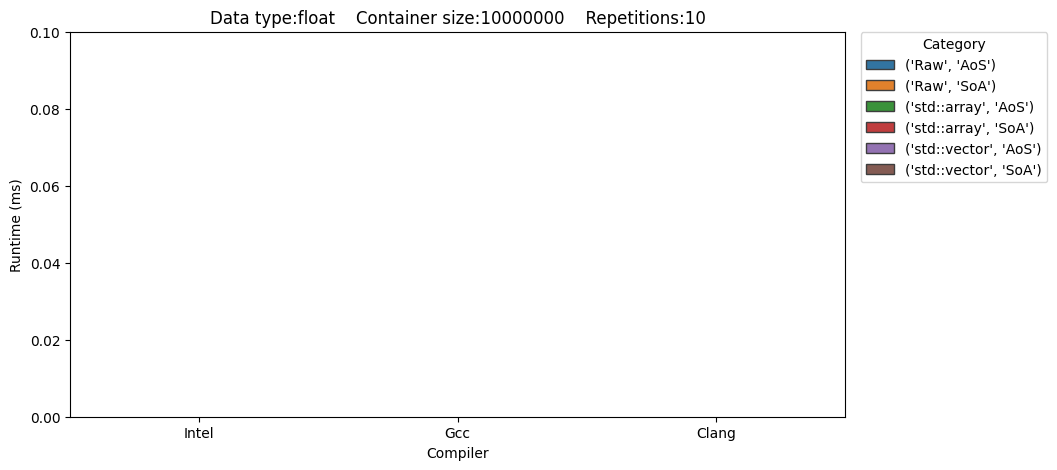

In [ ]:
selected_type = "float"
selected_size = df_runs["intel"]["size"].mean()
selected_reps = df_runs["intel"]["repetitions"].mean()

plt.figure(figsize=(10, 5))
plt.title(
    f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}"
)
data = {"Category": [], "Compiler": [], "Runtime": []}
for cmplr, avg, std in zip(compilers, df_mean.values(), df_std.values()):
    for i in range(num_tests):
        df_cmplr = df_runs[cmplr]
        runs = df_cmplr[(df_cmplr["family_index"] == i)]
        if np.all(runs["type"] == selected_type):
            data["Category"].extend(
                [(c, l) for c, l in zip(runs["container"], runs["layout"])]
            )
            data["Compiler"].extend(np.repeat(cmplr.title(), selected_reps))
            data["Runtime"].extend(runs["real_time"])

sns.boxplot(x="Compiler", y="Runtime", hue="Category", data=pd.DataFrame(data))

plt.ylim([0, 0.1])
plt.ylabel(f"Runtime ({df_runs["intel"]["time_unit"].values[0]})")
plt.legend(
    title="Category", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0
)

plt.show()

## Boxes plot

Text(0, 0.5, 'Runtime (ms)')

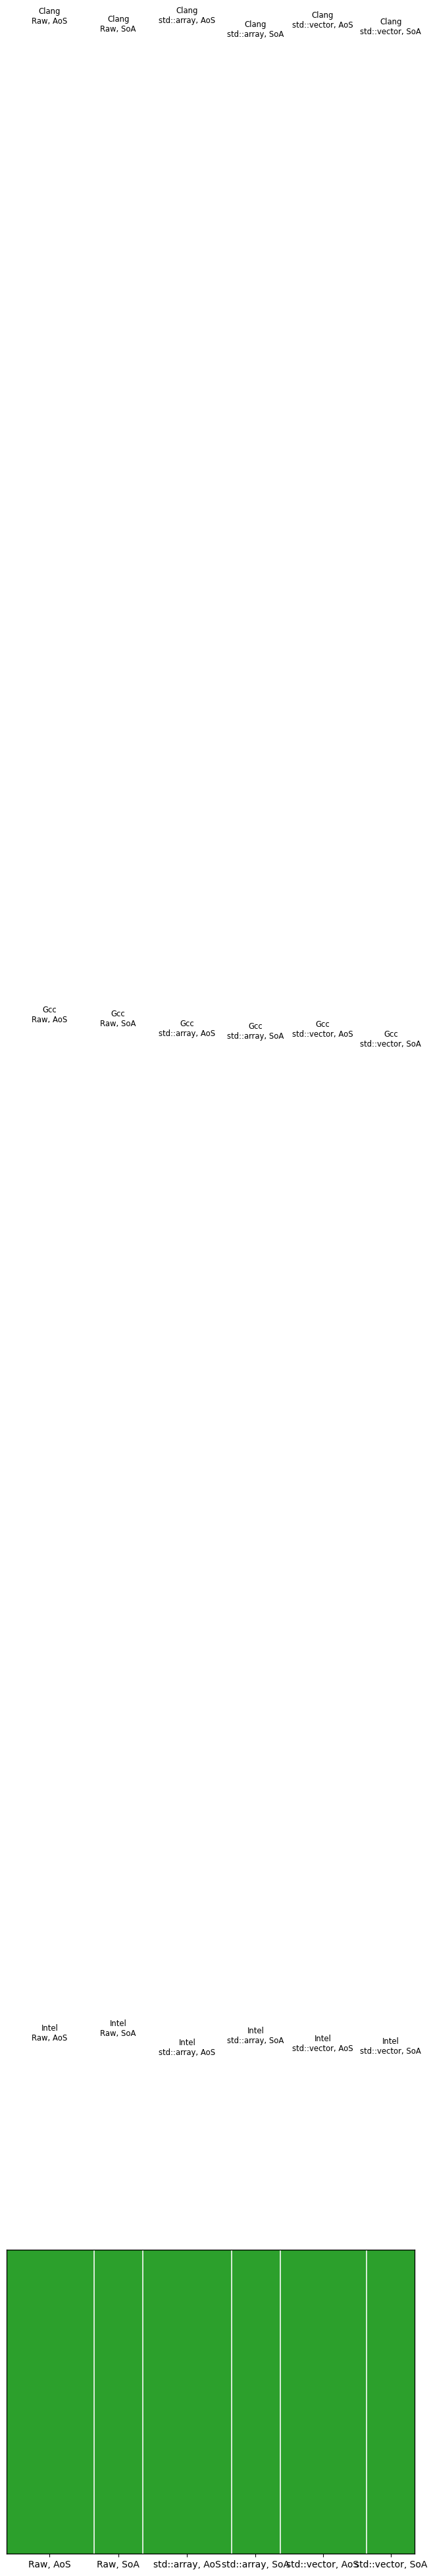

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic

selected_type = "double"
selected_size = df_runs["intel"]["size"].mean()
selected_reps = df_runs["intel"]["repetitions"].mean()

# plt.figure(figsize=(10,5))
# ax = plt.subplot(111)
fig, ax = plt.subplots(figsize=(8, 6))
plt.title(
    f"Data type:{selected_type}    Container size:{int(selected_size)}    Repetitions:{int(selected_reps)}"
)
data = {"Category": [], "Compiler": [], "Runtime": []}


for cmplr, avg, std in zip(compilers, df_mean.values(), df_std.values()):
    for i in range(num_tests):
        df_cmplr = df_mean[cmplr]
        runs = df_cmplr[(df_cmplr["family_index"] == i)]
        if np.all(runs["type"] == selected_type):
            data["Category"].append(
                f"{runs["container"].values[0]}, {runs["layout"].values[0]}"
            )
            data["Compiler"].append(cmplr.title())
            data["Runtime"].append(runs["real_time"])

# df = pd.DataFrame(data)

# # Convert crosstab to dictionary format needed for the mosaic plot
props = {
    (row, col): rt
    for row, col, rt in zip(data["Category"], data["Compiler"], data["Runtime"])
}

mosaic(
    props,
    labelizer=lambda k: f"{k[1]}\n{k[0]}",
    ax=ax,
    properties=lambda key: {"color": "C0" if key[1] == "AoS" else "C2"},
)  # Color based on 'animal'

plt.ylim([0, 0.1])
plt.ylabel(f"Runtime ({df_runs["intel"]["time_unit"].values[0]})")
# plt.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

# plt.show()

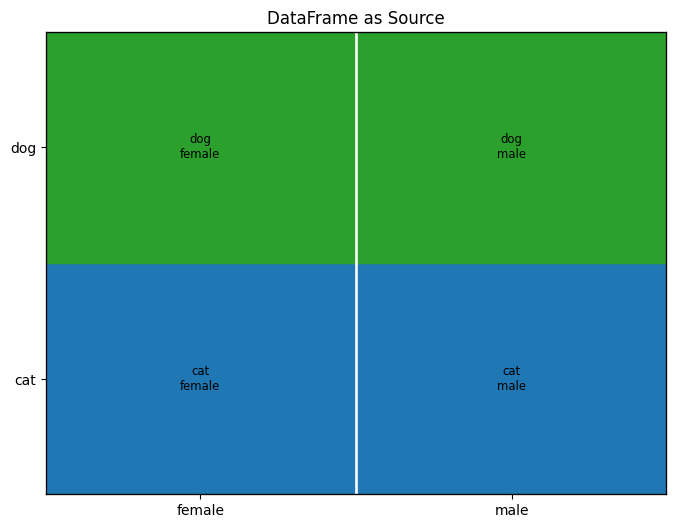

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample Data (Replace with your own data if needed)
data = pd.DataFrame(
    {
        "gender": [
            "female",
            "female",
            "male",
            "male",
            "female",
            "female",
            "male",
            "male",
        ],
        "animal": ["cat", "dog", "cat", "dog", "cat", "dog", "cat", "dog"],
    }
)

# Count occurrences for each category combination
cross_tab = pd.crosstab(data["gender"], data["animal"])

# Convert crosstab to dictionary format needed for the mosaic plot
props = {
    (row, col): cross_tab.loc[row, col]
    for row in cross_tab.index
    for col in cross_tab.columns
}

# Plot mosaic
fig, ax = plt.subplots(figsize=(8, 6))
mosaic(
    props,
    labelizer=lambda k: f"{k[1]}\n{k[0]}",
    ax=ax,
    properties=lambda key: {"color": "C0" if key[1] == "cat" else "C2"},
)  # Color based on 'animal'

# Customize plot
plt.title("DataFrame as Source")
plt.show()

In [ ]:
props

{('female', 'cat'): np.int64(2),
 ('female', 'dog'): np.int64(2),
 ('male', 'cat'): np.int64(2),
 ('male', 'dog'): np.int64(2)}

# False Sharing